In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sacrebleu.metrics import BLEU
from collections import Counter
from typing import Generator, Tuple

In [138]:
SOURCES = "../../data/en-fr/raw/test.fr"
REFERENCES = "../../data/en-fr/raw/test.en"
TRAIN_SOURCES_TOKENIZED = "../../data/en-fr/preprocessed/train.fr"
TEST_SOURCES_TOKENIZED = "../../data/en-fr/preprocessed/test.fr"

In [142]:
def shr_generator(hypotheses_path: str) -> Generator[Tuple[str, str, str, str], None, None]:
    with open(SOURCES, "r") as sources, open(hypotheses_path, "r") as hypotheses, open(REFERENCES, "r") as references, open(TEST_SOURCES_TOKENIZED) as source_tokenized:
        for s, h, r, st in zip(sources, hypotheses, references, source_tokenized):
            yield s.strip(), h.strip(), r.strip(), st.strip()

bleu = BLEU(effective_order=True)

word_counts = Counter()

with open(TRAIN_SOURCES_TOKENIZED) as f:
    for line in f:
        word_counts += Counter(line.strip().split(" "))

def unknown_ratio(tokenized_sentence: str) -> float:
    unknown = 0
    total = 0
    for token in tokenized_sentence.split(" "):
        if token not in word_counts:
            unknown += 1
        total += 1
    return unknown / total

def rare_ratio(tokenized_sentence: str, threshold: float = 0.001) -> float:
    rare = 0
    total = 0
    train_size = sum(word_counts.values())
    for token in tokenized_sentence.split(" "):
        if word_counts[token] / train_size < threshold:
            rare += 1
        total += 1
    return rare / total

def rare(tokenized_sentence: str, threshold: float = 0.001) -> int:
    rare = 0
    total = 0
    train_size = sum(word_counts.values())
    for token in tokenized_sentence.split(" "):
        if word_counts[token] / train_size < threshold:
            rare += 1
        total += 1
    return rare

def load_data(hypotheses_path: str) -> pd.DataFrame:
    shr = [x for x in shr_generator(hypotheses_path)]
    df = pd.DataFrame(shr, columns=["source", "hypothesis", "reference", "source_tokenized"])
    df["bleu"] = df.apply(lambda row: bleu.sentence_score(row["hypothesis"], [row["reference"]]).score, axis=1)
    df["source_len"] = df["source"].apply(lambda source: len(str(source)))
    df["unknown_ratio"] = df["source_tokenized"].apply(unknown_ratio)
    df["rare"] = df["source_tokenized"].apply(rare)
    df["rare_ratio"] = df["source_tokenized"].apply(rare_ratio)
    return df

In [143]:
SERIES = [
    {"label": "baseline",    "color": "red", "data": load_data("baseline/translations.p.txt")},
    {"label": "bytepair",         "color": "blue", "data": load_data("spm_vanilla/translations/postprocessed_spm_vanilla_fully_trained.txt")},
    {"label": "BT_baseline", "color": "green",   "data": load_data("backtranslation/doubledata_baseline/translations.txt")},
    {"label": "BT_bytepair", "color": "orange",   "data": load_data("backtranslation/doubledata_spm/translations.txt")}
]

In [145]:
def scatter(x, y, **kwargs):
    for series in SERIES:
        plt.scatter(series["data"][x], series["data"][y], c=series["color"], label=series["label"], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

def grouped_line(x, y, bins=10):
    for series in SERIES:
        grouped = series["data"].groupby(pd.cut(series["data"][x], bins=bins)).mean()
        grouped[y].plot(label=series["label"], c=series["color"])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

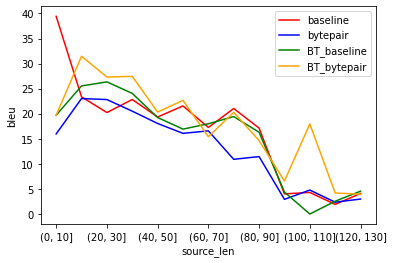

In [146]:
grouped_line("source_len", "bleu", bins=range(0, 150, 10))

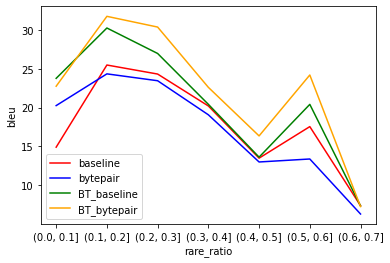

In [147]:
grouped_line("rare_ratio", "bleu", bins=np.arange(0, 1, 0.1))

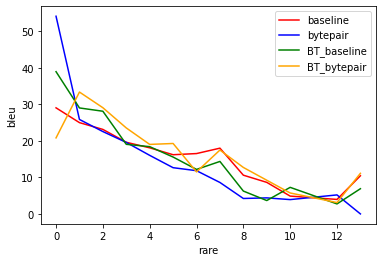

In [151]:
def grouped_line_nobin(x, y):
    for series in SERIES:
        grouped = series["data"].groupby(series["data"][x]).mean()
        grouped[y].plot(label=series["label"], c=series["color"])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    
grouped_line_nobin("rare", "bleu")

In [101]:
df[df["bleu"] > 80]

,source,hypothesis,reference,source_tokenized,bleu,source_len,unknown_ratio,rare_ratio
24,Vous êtes chanceuse d'avoir un emploi.,You're lucky to have a job.,You're lucky to have a job.,vous êtes chanceuse d&apos; avoir un emploi .,100.000000,38,0.000000,0.250000
86,Je sais que tu veux rentrer chez toi.,I know you want to go home.,I know you want to go home.,je sais que tu veux rentrer chez toi .,100.000000,37,0.000000,0.222222
89,Je pense que Tom est réveillé.,I think Tom is awake.,I think Tom is awake.,je pense que Tom est réveillé .,100.000000,30,0.000000,0.142857
140,Il s'y trouve une table.,There's a table.,There's a table.,il s&apos; y trouve une table .,100.000000,24,0.000000,0.285714
145,Il était patient.,He was patient.,He was patient.,il était patient .,100.000000,17,0.000000,0.250000
211,Je sais que vous êtes amoureux de moi !,I know you're in love with me!,I know you're in love with me.,je sais que vous êtes amoureux de moi !,84.089642,39,0.000000,0.111111
241,Vous êtes trop vieux pour moi.,You're too old for me.,You're too old for me.,vous êtes trop vieux pour moi .,100.000000,30,0.000000,0.142857
256,Puis-je demander qui ?,Can I ask who?,Can I ask who?,puis @-@ je demander qui ?,100.000000,22,0.000000,0.333333
280,Ne sais-tu pas son nom ?,Don't you know his name?,Don't you know his name?,ne sais @-@ tu pas son nom ?,100.000000,24,0.000000,0.125000
307,Quelle est l'idée ?,What's the idea?,What's the idea?,quelle est l&apos; idée ?,100.000000,19,0.000000,0.400000


Text(30.375, 0.5, 'Precision')

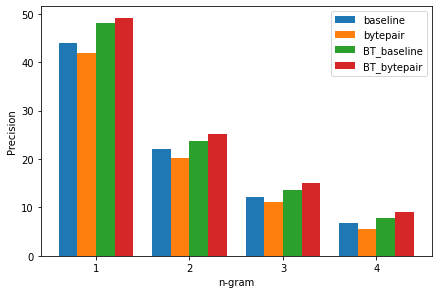

In [102]:
simpleseries = [
    {"label": "baseline", "data": [44.0, 22.1, 12.2, 6.7], "datax": ["1", "2", "3", "4"], "color": "red"},
    {"label": "bytepair", "data": [41.9, 20.2, 11.1, 5.6], "datax": ["1", "2", "3", "4"], "color": "blue"},
    {"label": "BT_baseline", "data": [48.2, 23.7, 13.5, 7.9], "datax": ["1", "2", "3", "4"], "color": "green"},
    {"label": "BT_bytepair", "data": [49.1, 25.1, 15.0, 9.0], "datax": ["1", "2", "3", "4"], "color": "orange"}
]

x = np.arange(4)
width = 0.2
fig, ax = plt.subplots()

c = 0
for series in simpleseries:
    rects = ax.bar(x - width*1.5 + c*width, series["data"], width, label=series["label"])

    c += 1

ax.set_xticks(x)
ax.set_xticklabels(["1", "2", "3", "4"])
ax.legend()
fig.tight_layout()

plt.xlabel("n-gram")
plt.ylabel("Precision")

In [153]:
df = SERIES[3]["data"]
upper_bound = 0.5
ratio_df = df[(df["rare_ratio"] > upper_bound - 0.1) & (df["rare_ratio"] <= upper_bound)]
ratio_df["source_len"].median()


42.0